# Transfer Learning for Computer Vision Tutorial
This notebook trains different kind of models, Resnet18, Resnet50, Alexnet, and EfficientNet, on the dataset given in the `dataset` directory. It is adapted from a pytorch tutorial to learn [transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).
This could be extended to work on mobile using the tutorial of [Adrian](https://medium.com/@adrian.errea.lopez/from-pytorch-model-to-mobile-application-50bc5729ed83)

In [2]:
# Import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights

cudnn.benchmark = True
plt.ion()   # interactive mode

### Load Datasets
The first code block loads the given dataset, and the second one shows a sample of the images in the dataset in order to verify that the dataset is loaded correctly.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the data
data_dir = 'datasets/melanoma_dataset'
image_datasets = {kind: datasets.ImageFolder(os.path.join(data_dir, kind), data_transforms[kind]) for kind in ['train', 'val']}
dataloaders = {kind: torch.utils.data.DataLoader(image_datasets[kind], batch_size=4, shuffle=True, num_workers=4) for kind in ['train', 'val']}
dataset_sizes = {kind: len(image_datasets[kind]) for kind in ['train', 'val']}
class_names = image_datasets['train'].classes

# Use Cuda if available, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Data loaded on {device}")

Data loaded on cuda:0


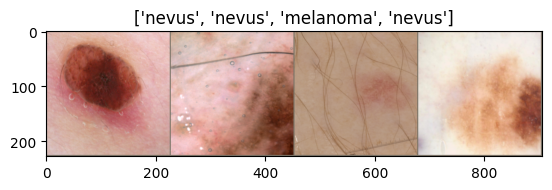

In [5]:
# Test cell to visualize the training data.
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Model Training
Provides a function to retrain the model on the provided dataset. It uses a temporary directory to store the best model weights while going through the training process.
After the function has ended it will set the best model weights to the model and return the model.<br>
Note that it will not train the model here, it only provides the function to train the model.

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

### Train a model
First a function is defined to let us choose a pretrained model from the torchvision.models module. Then the model is trained on the dataset using the function defined above. The model is then saved to the `models` directory.

If you want to choose which model to train you can use the python slicers on the `models` list. For example, `models[0:2]` will train the first two models in the list..

In [ ]:
## Choose a pretrained model to build up on
def create_model(model_name, num_classes=2):
    if model_name == "resnet18":
        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "resnet50":
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "efficientnet":
        model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Invalid model name")
    return model

#### Train and save multiple models

In [7]:
## Train each model
for model_name in ["resnet18", "resnet50", "alexnet", "efficientnet"]:
    ## Setup model
    model_ft = create_model(model_name)
    
    # link the model to the CPU or CUDA
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    ## Train the model for 25 epoch
    print(f"# Training {model_name}")
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
    
    ## Save the best mode
    torch.save(model_ft.state_dict(), f"./models/{model_name}_model.pt")

NameError: name 'ResNet50_Weights' is not defined

### Visualize the model to test it works

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

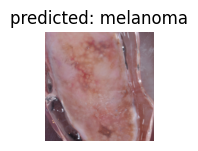

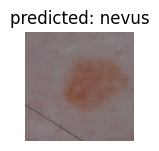

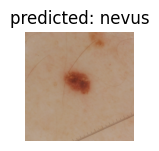

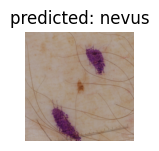

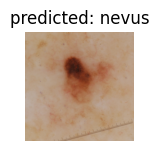

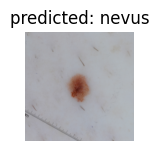

In [11]:
visualize_model(model_ft)

### Fix CUDA Cache
If the cache of CUDA is filled up and you can use the code below to clear it up. Ensure that the kernel is restarted first.

In [ ]:
# Empty Cuda cache, temp fix. Restart kernel first
import torch
torch.cuda.empty_cache()